<a href="https://colab.research.google.com/github/vgorbikov/image_processing/blob/main/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мультиклассовая классификация с использованием Pytorch

В этом задании вам предстоит решить задачу классификации используя фреймворк Pytorch. Необходимо выбрать **один из предлагаемых датасетов**:

- Распознавание жестов [[Homepage](https://www.kaggle.com/datasets/ayuraj/asl-dataset)]
- Классификация изображений медуз [[Homepage](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types)]

*Ссылки на скачивание датасетов вы сможете найти на странице задания в системе Moodle*.

В папке помимо картинок вы найдете `.csv` файлы, в которых хранится информация о разбиении данных на тренировочную и валидационную части, а также метки класса, к которому изображения принадлежат.

Вам необходимо реализовать полный цикл обучения, начиная с подготовки и загрузки данных, заканчивая созданием модели сверточной нейронной сети.

**В ноутбуке вам необходимо**:
- Отобразить 2-3 картинки из датасета и подписать соответствующий ей класс
- Создать Dataloaders
- Собрать модель сверточной нейронной сети (ограничений по архитектуре нет)
- На каждой эпохе выводить значения тренировочного и валидационного **лосса**, а также **метрик** (будем использовать Accuracy и AUC-ROC; пользоваться готовыми реализациями метрик можно).
- В конце построить график зависимости лосса и метрик от номера эпохи.

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
# YOUR CODE HERE
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchmetrics

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
dataset_path = '/content/drive/My Drive/assignments/03_classification/asl'

Mounted at /content/drive/


In [3]:
#Загружаем изображения
images = []
img_classes = []

imgs_classes_path = dataset_path + '/images'
for img_cls in os.listdir(imgs_classes_path):
  current_class_path = imgs_classes_path + f'/{img_cls}'
  print(f'- Load class {img_cls}')

  for img_name in os.listdir(current_class_path):
    img_path = current_class_path + f'/{img_name}'
    img = imread(img_path)[::4,::4]

    if len(img_classes)>1:
        position = random.randint(0, len(img_classes)-1)
    else:
       position = 0

    images.insert(position, img)
    img_classes.insert(position, img_cls)



images = np.array(images)
print(f'Размер загруженного массива изображений: {images.shape}')
# np.savetxt(dataset_path+'/images_asl.txt', images.flatten())

- Load class 1
- Load class 2
- Load class 5
- Load class 0
- Load class 6
- Load class 4
- Load class 3
- Load class 7
- Load class e
- Load class a
- Load class d
- Load class c
- Load class 8
- Load class f
- Load class 9
- Load class b
- Load class h
- Load class g
- Load class k
- Load class o
- Load class n
- Load class i
- Load class m
- Load class p
- Load class j
- Load class l
- Load class q
- Load class r
- Load class t
- Load class s
- Load class x
- Load class v
- Load class w
- Load class z
- Load class u
- Load class y
Размер загруженного массива изображений: (2515, 100, 100, 3)


In [4]:
#Создаём словарь классов
tmp_classet = sorted(set(img_classes))
img_classcodes = {tmp_classet[i]:np.zeros(len(tmp_classet)) for i in range(len(tmp_classet))}
for i in range(len(tmp_classet)):
  img_classcodes[tmp_classet[i]][i] = 1

img_classcodes_inv = {np.argmax(i[1]):i[0] for i in img_classcodes.items()} # Словарь вида {argmax_index: class}

img_classes_cat = np.array([img_classcodes[cls] for cls in img_classes]) # Классы в виде ввекторов

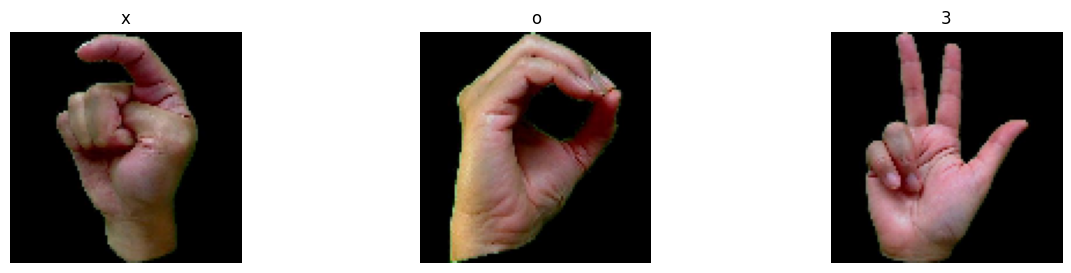

In [5]:
# Предпросмотр изображений выобрки
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i in range(3):
  img_no = random.randint(0, len(img_classes)-1)
  axes[i].imshow(images[img_no])
  axes[i].set_title(img_classcodes_inv[np.argmax(img_classes_cat[img_no])])
  axes[i].axis('off')

fig.show()

In [6]:
class DatasetASL(Dataset):

    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __getitem__(self, index):
        """Load and return a sample from the dataset at the given index."""
        img = self.x_data[index]

        # augmentations
        if self.transform is not None:
            img = self.transform(img)

        label = torch.from_numpy(self.y_data[index])

        return img, label

    def __len__(self):
        """Return the number of samples in dataset."""
        return len(self.x_data)

In [7]:
class DatamoduleASL():
    """Create dataset and loaders, apply transforms."""

    def __init__(self):
        # load data
        (self.x_train, self.y_train), (self.x_test, self.y_test) = (np.copy(images[0:2200]), np.copy(img_classes_cat[0:2200])), (np.copy(images[2200:2515]), np.copy(img_classes_cat[2200:2515]))
        # (self.x_train, self.y_train), (self.x_test, self.y_test) = (np.copy(images), np.copy(img_classes_cat)), (np.copy(images), np.copy(img_classes_cat))

        # make dataset smaller if needed
        # self.x_train = self.x_train[:1000]
        # self.y_train = self.y_train[:1000]
        # self.x_test = self.x_test[:1000]
        # self.y_test = self.y_test[:1000]

    def create_loaders(self, batch_size=10):
        """Create loaders both for train and test/validation datasets."""

        # train dataset
        dset_train = DatasetASL(self.x_train, self.y_train, transform=transforms.ToTensor())
        # test dataset
        dset_test = DatasetASL(self.x_test, self.y_test, transform=transforms.ToTensor())

        # Train and test dataloaders
        train_loader = DataLoader(dset_train, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(dset_test, batch_size=5, shuffle=False)

        return train_loader, test_loader

In [9]:
# Создаём загрузчики данных
train_loader, test_loader = DatamoduleASL().create_loaders(20)

In [24]:
# Создаём модель
cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(in_features=12 * 12 * 16, out_features=36)
        ).cuda()

# Функция ошибки и оптимизатор
loss_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=1e-3)

# Метрики
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=36)
prec = torchmetrics.Precision(task='multiclass', num_classes=36)



def train(model, train_loader, test_loader, epoch_count=5):
    model.train(True)
    train_loss_stat = []
    train_acc_stat = []
    train_prec_stat = []

    for epoch_no in range(epoch_count):

            loss_batches = []
            preds_train = []
            labels_train = []

            # train
            for step, (images, labels) in enumerate(train_loader):

                # to cuda
                images = images.cuda()
                labels = labels.type(torch.FloatTensor).cuda()

                # make prediction
                raw_preds = model(images)
                # calculate loss
                loss = loss_ce(raw_preds, labels)

                # update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # save loss
                loss_batches.append(loss.item())

                # predictions
                preds = torch.argmax(nn.Softmax(dim=1)(raw_preds), dim=1)

                preds_train.append(preds)
                labels_train.append(torch.tensor([torch.argmax(l) for l in labels]))


            #find metrics in the end of the epoch
            predictions = torch.cat([preds for preds in preds_train]).cpu()
            labels = torch.cat([labels for labels in labels_train]).cpu()

            acc_train = accuracy(predictions, labels)
            prec_train = prec(predictions, labels)

            train_loss_stat.append(np.mean(loss_batches))
            train_acc_stat.append(acc_train)
            train_prec_stat.append(prec_train)

            print(f"Epoch: {epoch_no}")
            print(f"TRAIN | Loss: {np.mean(loss_batches): .3f}, Train_acc: {acc_train: .3f}, Train_prec: {prec_train: .3f}")

            loss_batches = []
            preds_train = []
            labels_train = []

            with torch.no_grad():
              for step, (images, labels) in enumerate(test_loader):

                # to cuda
                images = images.cuda()
                labels = labels.type(torch.FloatTensor).cuda()

                # make prediction
                raw_preds = model(images)
                # calculate loss
                loss = loss_ce(raw_preds, labels)

                # save loss
                loss_batches.append(loss.item())

                # predictions
                preds = torch.argmax(nn.Softmax(dim=1)(raw_preds), dim=1)

                preds_train.append(preds)
                labels_train.append(torch.tensor([torch.argmax(l) for l in labels]))


            #find metrics in the end of the epoch
            predictions = torch.cat([preds for preds in preds_train]).cpu()
            labels = torch.cat([labels for labels in labels_train]).cpu()

            acc_train = accuracy(predictions, labels)
            prec_train = prec(predictions, labels)

            print(f"TEST | Loss: {np.mean(loss_batches): .3f}, Test_acc: {acc_train: .3f}, Test_prec: {prec_train: .3f}")

    return train_loss_stat, train_acc_stat, train_prec_stat


In [25]:
losstat, accstat, precstat = train(cnn_model, train_loader, test_loader, epoch_count=30)


Epoch: 0
TRAIN | Loss:  1.619, Train_acc:  0.543, Train_prec:  0.543
TEST | Loss:  0.592, Test_acc:  0.806, Test_prec:  0.806
Epoch: 1
TRAIN | Loss:  0.340, Train_acc:  0.886, Train_prec:  0.886
TEST | Loss:  0.246, Test_acc:  0.927, Test_prec:  0.927
Epoch: 2
TRAIN | Loss:  0.143, Train_acc:  0.955, Train_prec:  0.955
TEST | Loss:  0.188, Test_acc:  0.937, Test_prec:  0.937
Epoch: 3
TRAIN | Loss:  0.074, Train_acc:  0.977, Train_prec:  0.977
TEST | Loss:  0.165, Test_acc:  0.943, Test_prec:  0.943
Epoch: 4
TRAIN | Loss:  0.050, Train_acc:  0.983, Train_prec:  0.983
TEST | Loss:  0.161, Test_acc:  0.946, Test_prec:  0.946
Epoch: 5
TRAIN | Loss:  0.048, Train_acc:  0.984, Train_prec:  0.984
TEST | Loss:  0.107, Test_acc:  0.965, Test_prec:  0.965
Epoch: 6
TRAIN | Loss:  0.026, Train_acc:  0.993, Train_prec:  0.993
TEST | Loss:  0.121, Test_acc:  0.959, Test_prec:  0.959
Epoch: 7
TRAIN | Loss:  0.011, Train_acc:  0.998, Train_prec:  0.998
TEST | Loss:  0.109, Test_acc:  0.968, Test_prec:

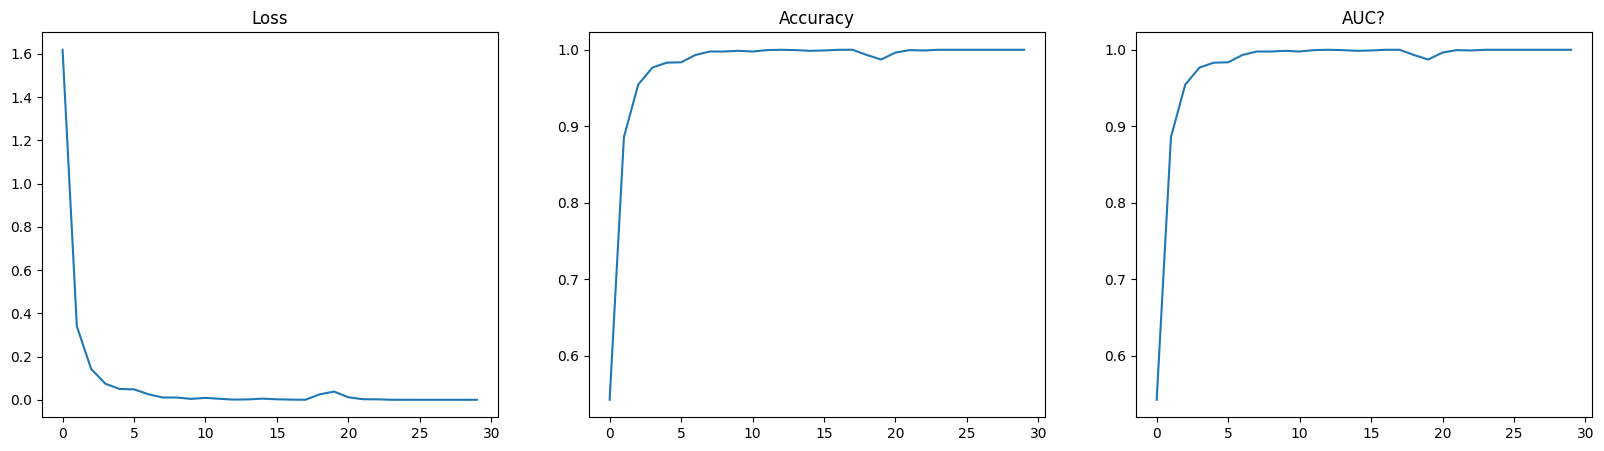

In [26]:
# Статистика
fig_stat, ax_stat = plt.subplots(1, 3, figsize=(20, 5))
accstat = [s.cpu() for s in accstat]
precstat = [s.cpu() for s in precstat]

ax_stat[0].plot(losstat)
ax_stat[0].set_title('Loss')
ax_stat[1].plot(accstat)
ax_stat[1].set_title('Accuracy')
ax_stat[2].plot(precstat)
ax_stat[2].set_title('AUC?')
fig_stat.show()

**Отлично, сеть полностью обучилась!**

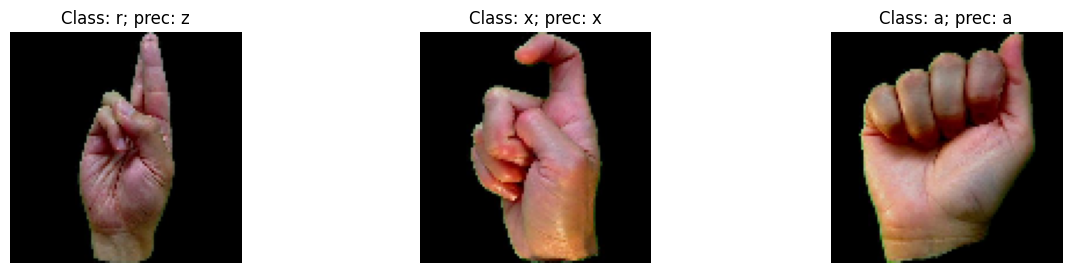

In [54]:
# Наглядно
fig, axes = plt.subplots(1, 3, figsize=(15, 3))


for i in range(3):
  img_no = random.randint(2200, len(img_classes)-1)
  img = torch.tensor(np.moveaxis([images[img_no]], -1, 1)).type(torch.FloatTensor).cuda()
  prec = torch.argmax(cnn_model.forward(img))
  axes[i].imshow(images[img_no])
  axes[i].set_title(f'Class: {img_classes[img_no]}; prec: {img_classcodes_inv[int(prec)]}')
  axes[i].axis('off')

fig.show()

Я долго искал пример с ошибкой чтобы доказать что подвоха нет :))

## **Перед отправкой сохраните ноутбук с именем в следующем формате: 03_Фамилия.ipynb**